# Step - 1 : Brief description of the problem and data 

#### Objective of this problem is to identify metastatic cancer in small image patches taken from larger digital pathology scans.

Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

#### Data is divided into train and test :
Train data contains 220025 images and test data contains 57458 images

Data is modified version of the PatchCamelyon (PCam) benchmark dataset. The original PCam dataset contains duplicate images. however, the version presented on Kaggle does not contain duplicates.

This is binary classification problem, Our target variable has a distribution of 40.5% as 1 (has cancer tissues) and 59.5% as 0 (has no cancer tissues)

objective is to train model on the image in train folder and then label the images in test folder, whether that image contains cancer tissue or not

## Loading Data and processing images

In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kaggle
import json
import zipfile
import os
from tensorflow.keras.preprocessing import image
from PIL import Image
import cv2
from tqdm import tqdm_notebook,trange
from tqdm.notebook import tqdm
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.utils import np_utils
import kaggle

In [2]:
basedir = '/Users/vishalverma/Vishal/git/Data/Cancer detection/Data/histopathologic-cancer-detection/'

In [3]:
sample_sub = pd.read_csv(basedir + 'sample_submission.csv')
train_df1 = pd.read_csv(basedir + 'train_labels.csv')

In [4]:
print('Number of training case : {}'.format(train_df1.shape[0]))
print('Number of test case : {}'.format(len(os.listdir(basedir + 'test/'))))

Number of training case : 220025
Number of test case : 57458


#### Processing images to matrix

In [5]:
def load_data(path,N,df):
    """ This functions loads N images using the data df
    """
    # allocate a numpy array for the images (N, 96x96px, 3 channels, values 0 - 255)
    X = np.zeros([N,96,96,3],dtype=np.uint8) 
    #convert the labels to a numpy array too
    y = np.squeeze(df.label.values)[0:N]
    #read images one by one, tdqm notebook displays a progress bar
    for i, row in tqdm(df.iterrows(), total=N):
        if i == N:
            break
        X[i] = cv2.imread(path + row['id'] + '.tif')
          
    return X,y

# Step - 2 : Exploratory data analysis

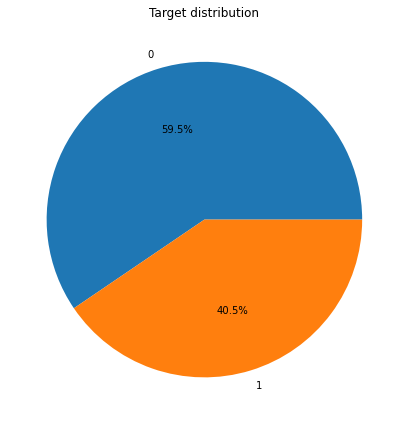

In [6]:
val1 = train_df1.label.value_counts(normalize=True).values
labels1 = train_df1.label.value_counts(normalize=True).index

fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(val1, labels=labels1, autopct='%.1f%%')
ax.set_title('Target distribution')
plt.tight_layout()

### Images details

In [7]:
image1 = image.load_img(basedir + 'train/' + train_df1.id[0] + '.tif')

# convert image to. a matrix
img_ts = image.img_to_array(image1)
print(img_ts.shape)

(96, 96, 3)


Each image size 96X96 pixel with 3 channel of RGB

In [8]:
img_lst = os.listdir(basedir + 'train/')

In [9]:
select_norm = np.random.choice(img_lst, 10, replace = False)

### Visualizing 10 images randomly

In [10]:
def visualize_img1(path1,img_list1,df1,plt_matrix):
    fig,axes = plt.subplots(plt_matrix[0],plt_matrix[1],figsize = (20,5))
    
    for indx,img in enumerate(img_list1):
        #print(indx//plt_matrix[1])
        axes[indx//plt_matrix[1], indx - (indx//plt_matrix[1])*(plt_matrix[1])].set_xticks([])
        axes[indx//plt_matrix[1], indx - (indx//plt_matrix[1])*(plt_matrix[1])].set_yticks([])
        axes[indx//plt_matrix[1], indx - (indx//plt_matrix[1])*(plt_matrix[1])].imshow(Image.open(path1 + img))
        axes[indx//plt_matrix[1], indx - (indx//plt_matrix[1])*(plt_matrix[1])].title.set_text('lable = {}'.format(df1[df1.id == img.split('.')[0]].label.values[0]))
    

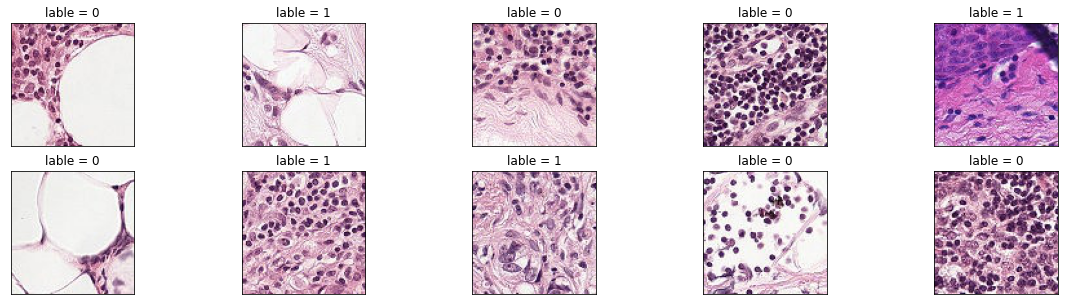

In [11]:
visualize_img1(basedir + 'train/',select_norm,train_df1,[2,5])

### Visualizing 10 image with label = 1

In [12]:
select_norm1 = np.random.choice(train_df1.id[train_df1.label == 1].tolist(),10,replace=False)
select_norm1 = [chr1 + '.tif' for chr1 in select_norm1]

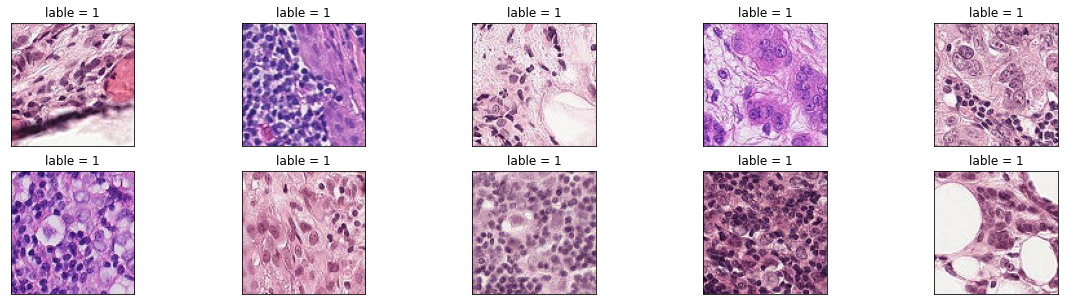

In [13]:
visualize_img1(basedir + 'train/',select_norm1,train_df1,[2,5])

### Visualizing 10 images with label = 0

In [14]:
select_norm3 = np.random.choice(train_df1.id[train_df1.label == 0].tolist(),10,replace = False)
select_norm3 = [chr1 + '.tif' for chr1 in select_norm3]

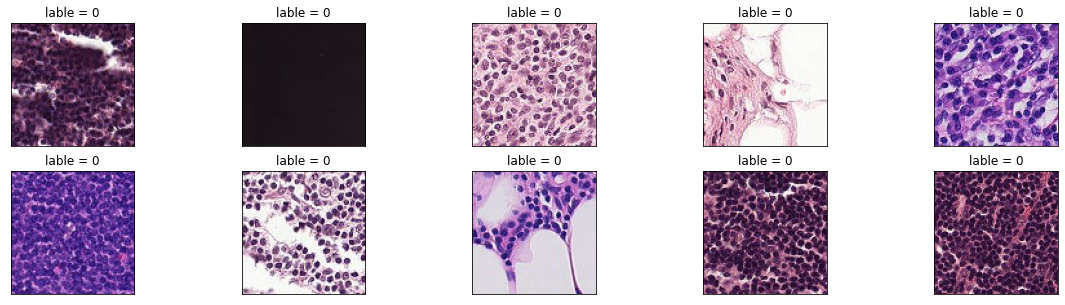

In [15]:
visualize_img1(basedir + 'train/',select_norm3,train_df1,[2,5])

In [131]:
N=25000
X,y = load_data(basedir + 'train/',N=N,df=train_df1)

  0%|          | 0/25000 [00:00<?, ?it/s]

In [132]:
positive_cases = X[y == 1]
negative_cases = X[y == 0]

In [133]:
positive_cases.shape

(10064, 96, 96, 3)

comparing pixel value for both negative vs positive

In [134]:
def rgb_plt1(axes,data1,bins,title,ylabel,xlabel):
    axes.hist(data1.flatten(),bins=bins,density = True)
    axes.set_title(title)
    axes.set_ylabel(ylabel,rotation='horizontal',labelpad=35,fontsize=12)
    axes.set_xlabel("Pixel value")
    
    return fig.tight_layout()
    

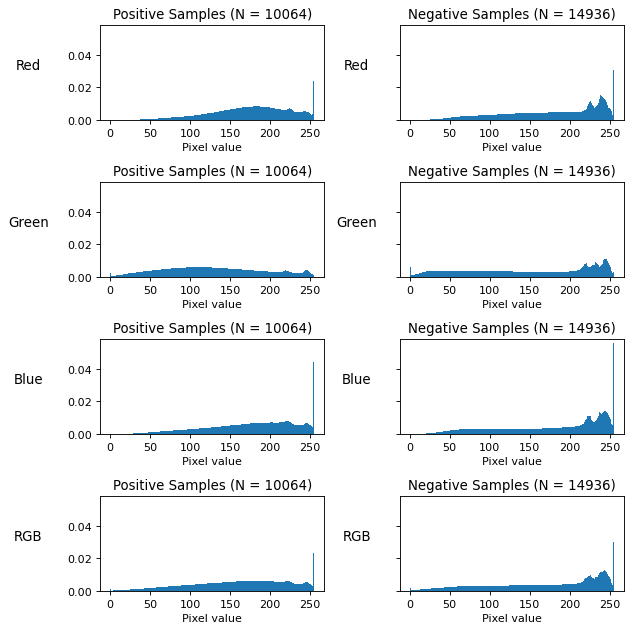

In [135]:
nr_of_bins = 256 #each possible pixel value will get a bin in the following histograms
fig,axs = plt.subplots(4,2,sharey=True,figsize=(8,8),dpi=80)

rgb_plt1(axs[0,0],positive_cases[:,:,:,0],nr_of_bins,
         'Positive Samples (N = {})'.format(str(positive_cases.shape[0])),'Red','Pixel value')

rgb_plt1(axs[0,1],negative_cases[:,:,:,0],nr_of_bins,
         'Negative Samples (N = {})'.format(str(negative_cases.shape[0])),'Red','Pixel value')

rgb_plt1(axs[1,0],positive_cases[:,:,:,1],nr_of_bins,
         'Positive Samples (N = {})'.format(str(positive_cases.shape[0])),'Green','Pixel value')

rgb_plt1(axs[1,1],negative_cases[:,:,:,1],nr_of_bins,
         'Negative Samples (N = {})'.format(str(negative_cases.shape[0])),'Green','Pixel value')
                       
rgb_plt1(axs[2,0],positive_cases[:,:,:,2],nr_of_bins,
         'Positive Samples (N = {})'.format(str(positive_cases.shape[0])),'Blue','Pixel value')

rgb_plt1(axs[2,1],negative_cases[:,:,:,2],nr_of_bins,
         'Negative Samples (N = {})'.format(str(negative_cases.shape[0])),'Blue','Pixel value')

rgb_plt1(axs[3,0],positive_cases,nr_of_bins,
         'Positive Samples (N = {})'.format(str(positive_cases.shape[0])),'RGB','Pixel value')

rgb_plt1(axs[3,1],negative_cases,nr_of_bins,
         'Negative Samples (N = {})'.format(str(negative_cases.shape[0])),'RGB','Pixel value')


High pixel value means brighter colour and low pixel value means darker colour.

We can see difference in the distribution of positive vs negative cases.

* In negative case we can see high pixel value compare to positive case.
* Comparatively green colour have low pixel value in positive case. Other channels are skewed toward 255 we are green channel shows normal distribution with high frequency at 100 pixel value.


### Mean pixel comparision

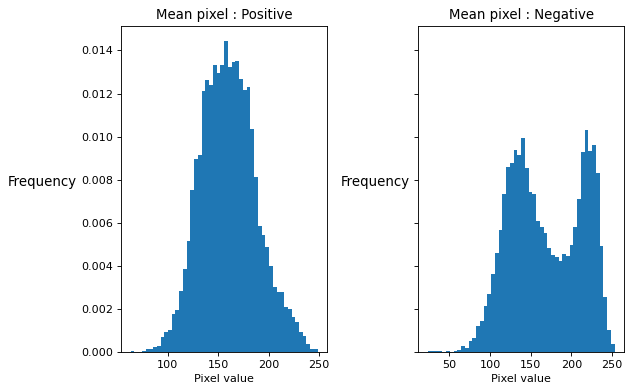

In [136]:
nr_of_bins = 50 
fig,axs = plt.subplots(1,2,sharey=True,figsize=(8,5),dpi=80)

rgb_plt1(axs[0],np.mean(positive_cases,axis = (1,2,3)),nr_of_bins,
         'Mean pixel : Positive'.format(str(positive_cases.shape[0])),'Frequency','Pixel value')

rgb_plt1(axs[1],np.mean(negative_cases,axis = (1,2,3)),nr_of_bins,
         'Mean pixel : Negative'.format(str(positive_cases.shape[0])),'Frequency','Pixel value')

comparing mean distribution we can see a significant different between both positive and negative case.
frequency is high at 150 pixel in positive cases whereas in negative case we see a drop in frequency between 150 and 200 range

#### Splitting data into test, train and validation set

To begin with we are building model only on 20000 images, we will first divide data into train,validation and test set

In [137]:
train_x, test_x, train_y, test_y = train_test_split(X, y, train_size = 0.8, random_state = 42)

val_size = int(0.5*len(test_x))

val_x = test_x[:val_size]
val_y = test_y[:val_size]
test_x = test_x[val_size:]
test_y = test_y[val_size:]

# Step - 3 and 4: DModel Architecture and hyper parameter tuning

I will keep model structure simple which includes

* Input layer
* Convolution layer
* Pool layer for parameter reduction
* Dropout to deal with overfitting
* Flatten
* Dense
* output

We will use following hyperparameters like:
* Filter size (kernel_size)
* Number of filter in each layer
* number of epochs
* batch size
* pooling

In [150]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128
optimizer = keras.optimizers.Adam()
loss_function = "binary_crossentropy"
no_epochs = 15
batch_size = 100

In [151]:
#create model
model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation='relu', input_shape=(96, 96, 3)))
model.add(MaxPool2D(pool_size))
model.add(Conv2D(second_filters, kernel_size, activation='relu'))
model.add(MaxPool2D(pool_size))
model.add(Conv2D(third_filters, kernel_size, activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1,activation='sigmoid'))

# Compile the model
model.compile(loss=loss_function,
              optimizer=optimizer,
              metrics=['accuracy'])

In [152]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5)
checkpointer = ModelCheckpoint(filepath='weights.hdf5', 
                               verbose=1, save_best_only=True)

In [153]:
# Fit data to model
history = model.fit(train_x, train_y,
                    validation_data=(val_x, val_y),
                    batch_size=batch_size,
                    epochs=no_epochs,
                    verbose = 1,
                    callbacks = [early_stopping, checkpointer])

Epoch 1/15


2022-05-23 17:46:14.559240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


200/200 [==============================] - ETA: 0s - loss: 8.6371 - accuracy: 0.7168

2022-05-23 17:46:40.487714: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.52405, saving model to weights.hdf5
200/200 [==============================] - 28s 134ms/step - loss: 8.6371 - accuracy: 0.7168 - val_loss: 0.5240 - val_accuracy: 0.7620
Epoch 2/15
200/200 [==============================] - ETA: 0s - loss: 0.5050 - accuracy: 0.7680
Epoch 2: val_loss did not improve from 0.52405
200/200 [==============================] - 26s 131ms/step - loss: 0.5050 - accuracy: 0.7680 - val_loss: 0.5550 - val_accuracy: 0.7208
Epoch 3/15
200/200 [==============================] - ETA: 0s - loss: 0.5857 - accuracy: 0.7214
Epoch 3: val_loss did not improve from 0.52405
200/200 [==============================] - 27s 137ms/step - loss: 0.5857 - accuracy: 0.7214 - val_loss: 0.6115 - val_accuracy: 0.6452
Epoch 4/15
200/200 [==============================] - ETA: 0s - loss: 0.5507 - accuracy: 0.7407
Epoch 4: val_loss improved from 0.52405 to 0.50169, saving model to weights.hdf5
200/200 [==============================] - 28s 140ms/step

# Step 5 - Conclusion

In [155]:
# Generate generalization metrics
score = model.evaluate(test_x, test_y, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

2022-05-23 17:53:07.539956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Test loss: 0.5544033646583557 / Test accuracy: 0.7912000417709351


As we can see we are getting test accuracty of 79.12% and validation accuracy was 78%

In [123]:
test_df1 = pd.DataFrame(os.listdir(basedir + 'test/'))

In [124]:
test_df1 = test_df1.iloc[:,0].str.split('.',expand = True)
test_df1.drop(1,axis = 1,inplace = True)
test_df1.rename(columns = {0:'id'},inplace = True)

In [125]:
test_df1['label'] = 0

In [127]:
N=test_df1.shape[0]
final_test_x,final_test_y = load_data(basedir + 'test/',N=N,df=test_df1)

  0%|          | 0/57458 [00:00<?, ?it/s]

In [128]:
y_pred_keras = model.predict_generator(final_test_x, verbose=1)

/var/folders/xf/6fdb6j7912v8q7z1m24hkzlw0000gn/T/ipykernel_47455/557378195.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred_keras = model.predict_generator(final_test_x, verbose=1)


   1/1796 [..............................] - ETA: 10:24

2022-05-23 15:40:39.397936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1796/1796 [==============================] - 20s 11ms/step


In [129]:
predictions = np.array(y_pred_keras)
test_df1['label'] = predictions
submission = test_df1[["id", "label"]]
submission.head()

,id,label
0,fd0a060ef9c30c9a83f6b4bfb568db74b099154d,0.855651
1,1f9ee06f06d329eb7902a2e03ab3835dd0484581,0.855476
2,19709bec800f372d0b1d085da6933dd3ef108846,0.633332
3,7a34fc34523063f13f0617f7518a0330f6187bd3,0.484411
4,93be720ca2b95fe2126cf2e1ed752bd759e9b0ed,0.182794


In [130]:
#submission
submission.to_csv('/Users/vishalverma/Vishal/git/kaggle_v7/Cancer detection/Results/cnn_model.csv', index = False, header = True)